## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
analysis_params = {
  "model_type": "lca",
  "model_name": "lca",
  "version": "0.0",
  "save_info": "analysis",
  "overwrite_analysis": False}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params["model_name"])

In [4]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info=analysis_params["save_info"])

ot_bf_indices = analyzer.ot_grating_responses["neuron_indices"]
ot_contrasts = analyzer.ot_grating_responses["contrasts"]
ot_phases = analyzer.ot_grating_responses["phases"]
ot_orientations = analyzer.ot_grating_responses["orientations"]
ot_best_phases = analyzer.ot_grating_responses["best_phases"]
ot_mean_activations = analyzer.ot_grating_responses["mean_responses"]

co_bf_indices = analyzer.co_grating_responses["neuron_indices"]
co_contrasts = analyzer.co_grating_responses["contrasts"]
co_phases = analyzer.co_grating_responses["phases"]
co_base_orientations = analyzer.co_grating_responses["base_orientations"]
co_mask_orientations = analyzer.co_grating_responses["mask_orientations"]
co_base_mean_responses = analyzer.co_grating_responses["base_mean_responses"]
co_test_mean_responses = analyzer.co_grating_responses["test_mean_responses"]

### BF Analysis & Iso-Response Contours

In [5]:
neuron_angles = analyzer.neuron_angles(analyzer.bf_stats)

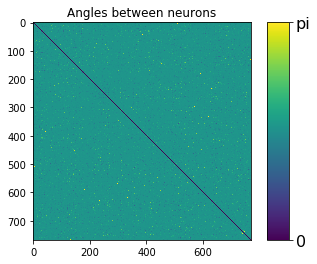

In [6]:
cmap = plt.get_cmap('viridis')
vmin = 0
vmax = np.pi
cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []
fig, ax = plt.subplots(1)
im = ax.imshow(neuron_angles)
ax.set_title("Angles between neurons")
cbar = fig.colorbar(scalarMap, ax=ax, ticks=[vmin, vmax], aspect=10)
cbar.ax.set_yticklabels(["0","pi"])
cbar.ax.tick_params(labelsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_angle_heatmap.png")
plt.show()

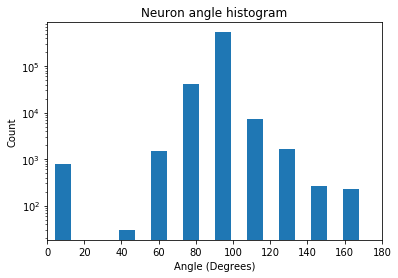

In [7]:
angles = neuron_angles[np.isfinite(neuron_angles)].flatten()*(180/np.pi)
xlims = [0, 180]
fig, ax = plt.subplots(1)
ax.hist(angles, rwidth=0.5, log=True)
ax.set_xlim(xlims)
ax.set_title("Neuron angle histogram")
ax.set_xlabel("Angle (Degrees)")
ax.set_ylabel("Count")
fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_angle_histogram.png")
plt.show()

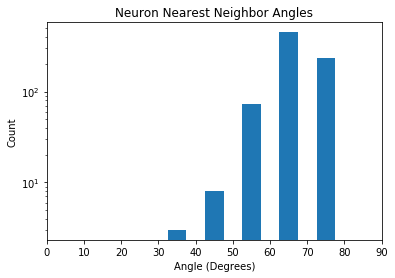

In [8]:
nn_angles = np.zeros(analyzer.bf_stats["num_outputs"])
for neuron_id in range(analyzer.bf_stats["num_outputs"]): 
  neighbors = neuron_angles[neuron_id,:] * (180/np.pi)
  nn_angles[neuron_id] = np.min(np.delete(neighbors, neuron_id))
fig, ax = plt.subplots(1)
ax.hist(nn_angles.flatten(), rwidth=0.5, bins=np.linspace(0,90,10), log=True)
ax.set_xlim([0, 90])
ax.set_title("Neuron Nearest Neighbor Angles")
ax.set_xlabel("Angle (Degrees)")
ax.set_ylabel("Count")
fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_neighbor_histogram.png")
plt.show()

num vectors =  5146
min angle =  0.6417214870452881  rad
min angle is at index  1333
BF indices = [ 0 ,  334 ]
vector angle	=  1.2645366191864014  rad
		=  72.4526113191226  deg
bf1 norm =  1.0
bf2 norm =  1.0


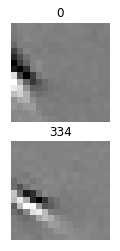

In [78]:
min_angle = 0.01
max_angle = 1.3
#min_angle = 1.55
#max_angle = 1.59

vectors = np.argwhere(np.logical_and(neuron_angles<max_angle, neuron_angles>min_angle))
print("num vectors = ", vectors.shape[0])

if vectors.shape[0] > 0:
  print("min angle = ", np.min(neuron_angles[vectors[:,0], vectors[:,1]]), " rad")
  print("min angle is at index ", np.argmin(neuron_angles[vectors[:,0], vectors[:,1]]))

  vector_id = 2#9
  bf_id1 = vectors[vector_id, 0]#max_indices[0]
  bf_id2 = vectors[vector_id, 1]#max_indices[1]
  print("BF indices = [",bf_id1,", ",bf_id2,"]")

  fig, ax = plt.subplots(2)
  ax[0] = pf.clear_axis(ax[0])
  ax[0].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
  ax[0].set_title(str(bf_id1))
  ax[1] = pf.clear_axis(ax[1])
  ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id2], cmap="Greys_r")
  ax[1].set_title(str(bf_id2))

  print("vector angle\t= ", neuron_angles[bf_id1, bf_id2], " rad\n\t\t= ", neuron_angles[bf_id1, bf_id2]*(180/np.pi), " deg")
  bf1 = analyzer.bf_stats["basis_functions"][bf_id1].reshape((analyzer.model_params["patch_edge_size"]**2))
  bf2 = analyzer.bf_stats["basis_functions"][bf_id2].reshape((analyzer.model_params["patch_edge_size"]**2))
  bf1_norm = np.linalg.norm(bf1)
  bf2_norm = np.linalg.norm(bf2)
  print("bf1 norm = ", bf1_norm)
  print("bf2 norm = ", bf2_norm)
  bf1 /= bf1_norm
  bf2 /= bf2_norm
else:
  assert False

In [255]:
num_imgs = 10000

proj_matrix = analyzer.bf_projections(bf1, bf2)
proj_neuron1 = np.dot(proj_matrix, bf1).T
proj_neuron2 = np.dot(proj_matrix, bf2).T

x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X, Y = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X.reshape(num_imgs), Y.reshape(num_imgs)], axis=1)

datapoints = np.stack([np.dot(proj_matrix.T, proj_datapoints[data_id,:]) for data_id in range(num_imgs)]) #inject
datapoints, orig_shape = dp.reshape_data(datapoints, flatten=False)[:2]
datapoints = {"test": Dataset(datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
datapoints = analyzer.model.preprocess_dataset(datapoints,
  params={"whiten_data":analyzer.model_params["whiten_data"],
  "whiten_method":analyzer.model_params["whiten_method"]})
datapoints = analyzer.model.reshape_dataset(datapoints, analyzer.model_params)
datapoints["test"].images /= np.max(np.abs(datapoints["test"].images))
datapoints["test"].images *= analyzer.analysis_params["input_scale"]

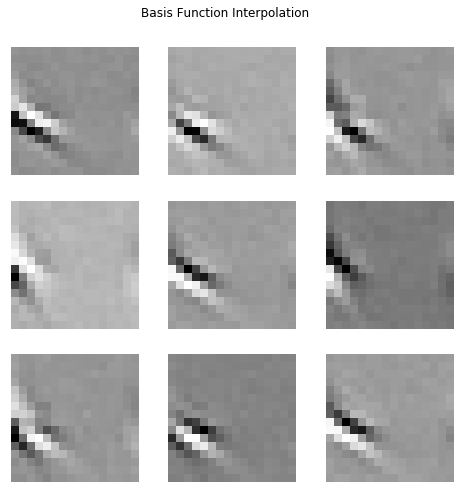

In [256]:
test_imgs = datapoints["test"].images.reshape([int(np.sqrt(num_imgs)), int(np.sqrt(num_imgs)), 16, 16])

num_plots_y = 3
num_plots_x = 3
gs = gridspec.GridSpec(num_plots_y, num_plots_x)
fig = plt.figure(figsize=(8,8))
half_sqrt_imgs = int(np.sqrt(num_imgs)/2)
filter_indices = [(0,0), (0, half_sqrt_imgs), (0, -1),
  (half_sqrt_imgs, 0), (half_sqrt_imgs, half_sqrt_imgs), (half_sqrt_imgs, -1),
  (-1, 0), (-1, half_sqrt_imgs), (-1, -1)]
filter_idx = 0
for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
  ax = pf.clear_axis(fig.add_subplot(gs[plot_id]))
  if filter_idx < num_imgs:
    ax.imshow(test_imgs[filter_indices[filter_idx][0], filter_indices[filter_idx][1], ...], cmap="Greys_r")
  filter_idx += 1
fig.suptitle("Basis Function Interpolation", y=0.95)
plt.show()

In [257]:
activations = analyzer.compute_activations(datapoints["test"].images)
activity_max = np.amax(np.abs(activations))
norm_activity = activations / (activity_max+0.0001)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca/checkpoints/lca_v0.0_weights-100000


INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca/checkpoints/lca_v0.0_weights-100000
num nonzero for bf1:  21
num nonzero for bf2:  12


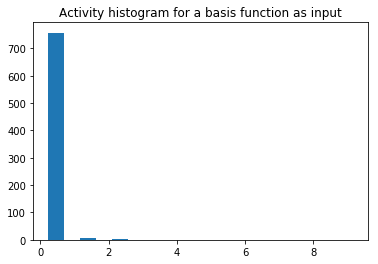

In [258]:
var_names = ["inference/activity:0"]
test_datapoints = analyzer.analysis_params["input_scale"]*np.squeeze(np.stack([bf1, bf2]))
test_activations = analyzer.evaluate_model(test_datapoints, var_names)["inference/activity:0"]
print("num nonzero for bf1: ", np.count_nonzero(test_activations[0,:]))
print("num nonzero for bf2: ", np.count_nonzero(test_activations[1,:]))
fig, ax = plt.subplots(1)
ax.hist(test_activations[1,:], rwidth=0.5)
ax.set_title("Activity histogram for a basis function as input")
plt.show()

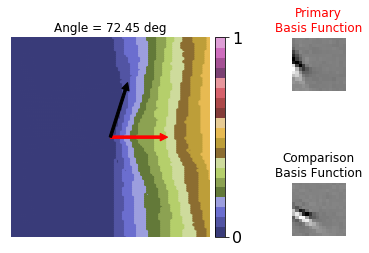

In [260]:
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
fig = plt.figure(figsize=(6, 6))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
cmap = plt.get_cmap('tab20b')
#cmap = plt.get_cmap('viridis')
#cmap = plt.get_cmap('jet')
vmin = np.floor(np.min(norm_activity))#0.0
vmax = np.ceil(np.max(norm_activity))#1.0
rank_indices = np.argsort(norm_activity[:, bf_id1])
pts = curve_ax.scatter(proj_datapoints[:,0][rank_indices], proj_datapoints[:,1][rank_indices],
  vmin=vmin, vmax=vmax, cmap=cmap, c=norm_activity[:,bf_id1][rank_indices], s=5.0)
curve_ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='r', ec='r')
curve_ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='k', ec='k')
curve_ax.set_title("Angle = "+"{:.2f}".format(neuron_angles[bf_id1, bf_id2]*(180/np.pi))+" deg")
curve_ax.set_ylim([-2, 2.0])
curve_ax.set_xlim([-2, 2.0])
curve_ax.set_aspect("equal")
cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.2)
bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
bf1_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
bf1_ax.set_title("Primary\nBasis Function", color='r')
bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
bf2_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id2], cmap="Greys_r")
bf2_ax.set_title("Comparison\nBasis Function", color='k')
fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_response_contours_bf0id"+str(bf_id1)+"_bf1id"+str(bf_id2)+".png")
plt.show()

Here we can either:
  * Compute a unit vector that is in the same plane as a given basis function pair (B1,B2) and is orthogonal to B1, where B1 is the target basis for comparison and B2 is selected from all other bases.
  * Construct a line of data points in this plane
  * Project the data points into image space, compute activations, plot activations

or

  * Construct the set of unit-length bases that are orthogonal to B1 (there should be B1.size-1 of them)
  * Construct a line of data points in each plane defined by B1 and a given orthogonal basis
  * Project the data points into image space, compute activations, plot activations

In [295]:
"""
 OPTION 2
"""
#pop_num_imgs = 10
#
#num_orthogonal = (analyzer.bf_stats["patch_edge_size"]**2)-1
#
#x_pts = [0.8,]*int(pop_num_imgs) # single slice in the 2-D contour plot
#y_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
#pop_proj_datapoints = np.stack([x_pts, y_pts], axis=1)
#
#pop_datapoints = [None,]*num_orthogonal
#pop_proj_neurons = [None,]*num_orthogonal
#for pop_idx in np.arange(num_orthogonal):
#  tmp_bf2 = np.zeros(analyzer.model_params["patch_edge_size"]**2)
#  tmp_bf2[pop_idx] = 1
#  tmp_bf2_norm = np.linalg.norm(bf2)
#  tmp_bf2 /= tmp_bf2_norm
#  tmp_proj_matrix = analyzer.bf_projections(bf1, tmp_bf2) #bf1 is rows (x), tmp_bf2 is columns (y)
#  pop_proj_neurons[pop_idx] = (np.dot(tmp_proj_matrix, bf1), np.dot(tmp_proj_matrix, tmp_bf2))
#  pop_datapoints[pop_idx] = np.stack([np.dot(tmp_proj_matrix.T, pop_proj_datapoints[data_id, :])
#    for data_id in range(pop_num_imgs)]) # inject
#
#pop_datapoints = np.reshape(np.stack(pop_datapoints, axis=0),
#  [num_orthogonal*pop_num_imgs, analyzer.model_params["patch_edge_size"]**2])
#pop_datapoints, orig_shape = dp.reshape_data(pop_datapoints, flatten=False)[:2]
#pop_datapoints = {"test": Dataset(pop_datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
#pop_datapoints = analyzer.model.preprocess_dataset(pop_datapoints,
#  params={"whiten_data":analyzer.model_params["whiten_data"],
#  "whiten_method":analyzer.model_params["whiten_method"]})
#pop_datapoints = analyzer.model.reshape_dataset(pop_datapoints, analyzer.model_params)
#pop_datapoints["test"].images /= np.max(np.abs(pop_datapoints["test"].images))
#pop_datapoints["test"].images *= analyzer.analysis_params["input_scale"]
#
#pop_activations = analyzer.compute_activations(pop_datapoints["test"].images)
#pop_activations = pop_activations.reshape([num_orthogonal, pop_num_imgs, analyzer.bf_stats["num_outputs"]])

'\n OPTION 2\n'

In [406]:
pop_num_imgs = 16

orthogonal_list = [idx for idx in range(analyzer.bf_stats["num_outputs"]) if idx != bf_id1]
num_orthogonal = len(orthogonal_list)

#x_pts = [0.8,]*int(pop_num_imgs) # single slice in the 2-D contour plot
x_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
y_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
X, Y = np.meshgrid(x_pts, y_pts)
pop_proj_datapoints = np.stack([X.reshape(pop_num_imgs**2), Y.reshape(pop_num_imgs**2)], axis=1) # construct a grid
x_target = x_pts[int(5*pop_num_imgs/8)] # find a location to take a slice
pop_proj_datapoints = np.squeeze(pop_proj_datapoints[np.where(pop_proj_datapoints[:,0]==x_target),:]) # slice grid

pop_datapoints = [None,]*num_orthogonal
pop_proj_neurons = [None,]*num_orthogonal
for pop_idx, bf2_idx in enumerate(orthogonal_list):
  tmp_bf2 = analyzer.bf_stats["basis_functions"][bf2_idx].reshape((analyzer.model_params["patch_edge_size"]**2))
  tmp_bf2 /= np.linalg.norm(bf2)
  tmp_proj_matrix = analyzer.bf_projections(bf1, tmp_bf2) 
  pop_proj_neurons[pop_idx] = (np.dot(tmp_proj_matrix, bf1).T, np.dot(tmp_proj_matrix, tmp_bf2).T)
  pop_datapoints[pop_idx] = np.stack([np.dot(pop_proj_datapoints[data_id, :][None,...], tmp_proj_matrix)
    for data_id in range(pop_num_imgs)], axis=0) # inject

pop_datapoints = np.reshape(np.stack(pop_datapoints, axis=0),
  [num_orthogonal*pop_num_imgs, analyzer.model_params["patch_edge_size"]**2])
pop_datapoints, orig_shape = dp.reshape_data(pop_datapoints, flatten=False)[:2]
pop_datapoints = {"test": Dataset(pop_datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
pop_datapoints = analyzer.model.preprocess_dataset(pop_datapoints,
  params={"whiten_data":analyzer.model_params["whiten_data"],
  "whiten_method":analyzer.model_params["whiten_method"]})
pop_datapoints = analyzer.model.reshape_dataset(pop_datapoints, analyzer.model_params)
pop_datapoints["test"].images /= np.max(np.abs(pop_datapoints["test"].images))
pop_datapoints["test"].images *= analyzer.analysis_params["input_scale"]

pop_activations = analyzer.compute_activations(pop_datapoints["test"].images)
pop_activations = pop_activations.reshape([num_orthogonal, pop_num_imgs, analyzer.bf_stats["num_outputs"]])
pop_norm_activations = pop_activations[:,:,bf_id1] / np.amax(np.abs(pop_activations[:,:,bf_id1]))

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca/checkpoints/lca_v0.0_weights-100000


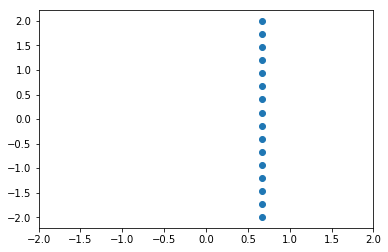

In [415]:
fig, ax = plt.subplots(1)
ax.scatter(pop_proj_datapoints[:,0], pop_proj_datapoints[:,1])
ax.set_xlim([-2,2])
plt.show()

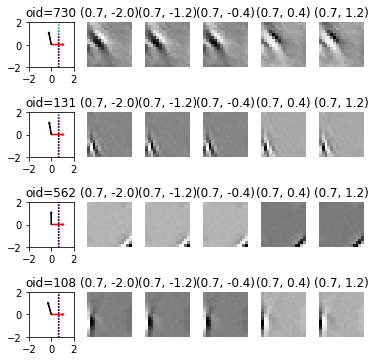

In [411]:
num_comparison_points = 5
num_plots_y = 4
num_plots_x = 1+num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.3)
fig = plt.figure(figsize=(6, 6))
for yid in range(num_plots_y):
  orthog_idx = np.random.choice(np.arange(num_orthogonal), replace=False)
  ax1 = fig.add_subplot(gs1[yid, 0])
  norm_activity = pop_norm_activations[orthog_idx, ...]

  cmap = plt.get_cmap('viridis')
  vmin = np.floor(np.min(norm_activity))#0.0
  vmax = np.ceil(np.max(norm_activity))#1.0
  rank_indices = np.argsort(norm_activity)
  pts = ax1.scatter(pop_proj_datapoints[:,0][rank_indices], pop_proj_datapoints[:,1][rank_indices],
    vmin=vmin, vmax=vmax, cmap=cmap, c=norm_activity[rank_indices], s=1.0)
  ax1.arrow(0, 0, pop_proj_neurons[orthog_idx][0][0].item(), pop_proj_neurons[orthog_idx][0][1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='r', ec='r')
  ax1.arrow(0, 0, pop_proj_neurons[orthog_idx][1][0].item(), pop_proj_neurons[orthog_idx][1][1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='k', ec='k')
  ax1.set_xlim([-2,2])
  ax1.set_ylim([-2,2])
  ax1.set_aspect("equal")
  ax1.set_title("oid="+str(orthog_idx))

  y_indices = np.arange(pop_num_imgs)[::int(pop_num_imgs/num_comparison_points)]
  if y_indices.size < num_comparison_points:
    y_indices.append(-1)
  for pid, xid in enumerate(range(1, num_plots_x)):
    ax = pf.clear_axis(fig.add_subplot(gs1[yid, xid]))
    imid = np.ravel_multi_index((orthog_idx, y_indices[pid]), (num_orthogonal, pop_num_imgs))
    ax.imshow(pop_datapoints["test"].images[imid, ...].reshape([analyzer.model_params["patch_edge_size"],
      analyzer.model_params["patch_edge_size"]]), cmap="Greys_r")
    subfig_title = ("({:.1f}, ".format(pop_proj_datapoints[y_indices[pid],0])
      +"{:.1f})".format(pop_proj_datapoints[y_indices[pid],1]))
    ax.set_title(subfig_title)

plt.show()

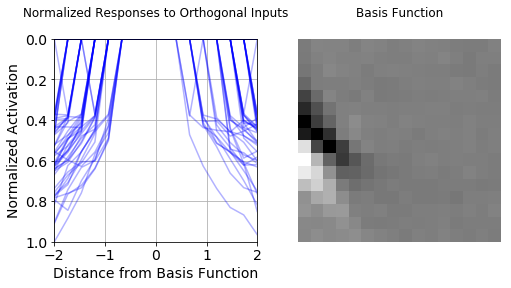

In [412]:
x_vals = pop_proj_datapoints[:,1]#y_pts
fig, ax = plt.subplots(1,2, figsize=(8,8))
for direction_idx in range(pop_norm_activations.shape[0]):
  ax[0].plot(x_vals, pop_norm_activations[direction_idx, :], color='b', alpha=0.3) # x_vals in the 2-D grid are plotted along the x axis
ax[0].set_title("Normalized Responses to Orthogonal Inputs", y=1.08)
ax[0].set_ylabel("Normalized Activation", fontsize=14)
ax[0].set_xlabel("Distance from Basis Function", fontsize=14)
ax[0].grid(True)
ax[0].set_ylim([1.0, 0.0])
ax[0].set_xlim([np.min(x_vals), np.max(x_vals)])
ax[0].set_aspect((np.max(x_vals)-np.min(x_vals))/(np.max(pop_norm_activations)-np.min(pop_norm_activations)))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
ax[1].set_title("Basis Function", y=1.08)
fig.savefig(analyzer.analysis_out_dir+"/vis/bf_curvatures.png")
plt.show()

In [297]:
coeffs = [np.polynomial.polynomial.polyfit(y_pts, line_list[idx,:], deg=2)
  for idx in range(line_list.shape[0])]
fits = [np.polynomial.polynomial.polyval(y_pts, coeff) for coeff in coeffs]
curvatures = [np.polyder(fit, m=2) for fit in fits]

IndexError: list index out of range

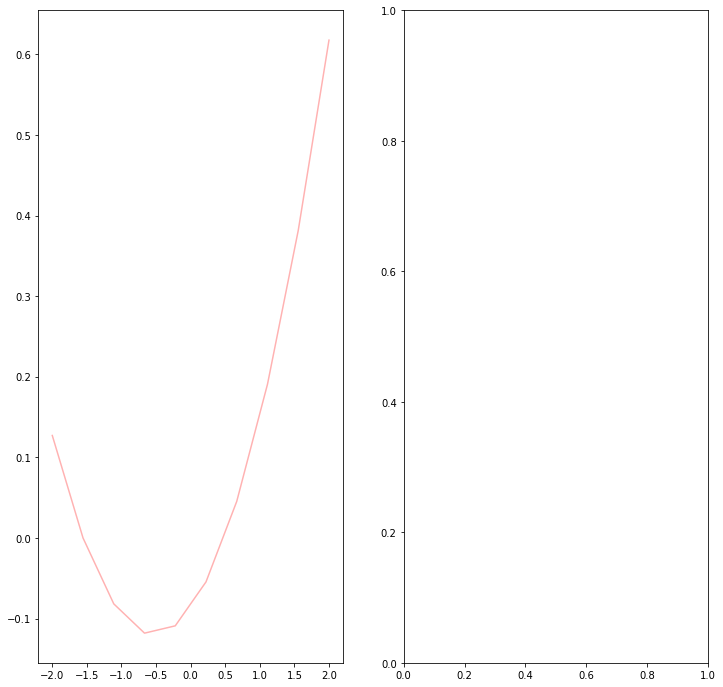

In [49]:
fig, ax = plt.subplots(1,2, figsize=(12,12))
for idx in range(line_list.shape[1]):
  ax[0].plot(y_pts, fits[idx], color='r', alpha=0.3)
ax[0].set_title("Normalized Responses to Orthogonal Inputs")
ax[0].set_ylabel("Normalized Activation", fontsize=14)
ax[0].set_xlabel("Distance from Basis Function", fontsize=14)
ax[0].grid(True)
ax[0].set_ylim([0.0,1.0])
ax[0].set_xlim([np.min(y_pts), np.max(y_pts)])
ax[0].set_aspect((np.max(y_pts)-np.min(y_pts))/(np.max(line_list)-np.min(line_list)))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
ax[1].set_title("Basis Function")
fig.savefig(analyzer.analysis_out_dir+"/vis/fit_curvatures.png")
plt.show()

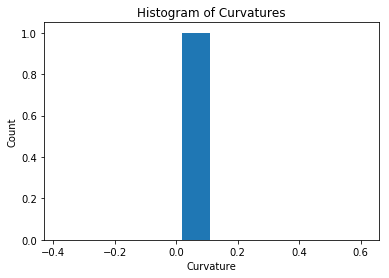

In [50]:
fig, ax = plt.subplots(1)
ax.hist(np.stack(coeffs, axis=0)[:,2], align="mid", rwidth=0.9)
ax.set_title("Histogram of Curvatures")
ax.set_xlabel("Curvature")
ax.set_ylabel("Count")
fig.savefig(analyzer.analysis_out_dir+"/vis/histogram_of_curvatures.png")
plt.show()

In [21]:
concavity = np.asarray([np.sign(coeffs[idx][2]) for idx in range(len(coeffs))])
num_equivariant = np.sum(concavity>0)
num_invariant = np.sum(concavity<0)
print("num equivariant:", num_equivariant, " num invariant:", num_invariant)

num equivariant: 94  num invariant: 0


In [321]:
type(indices[0])

numpy.ndarray

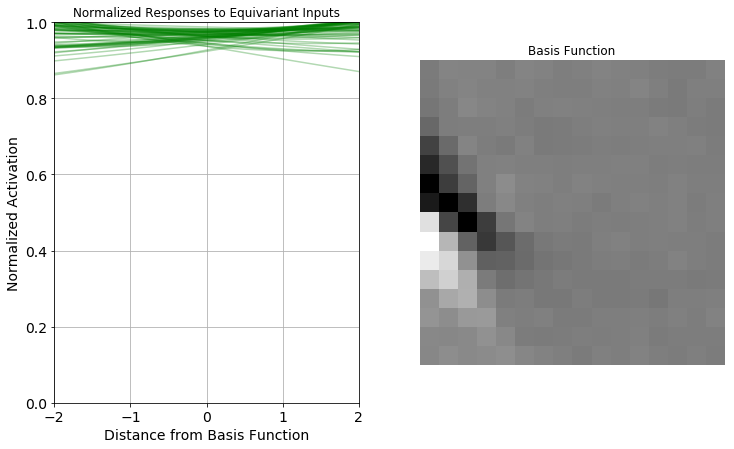

In [324]:
indices = np.where(concavity>0)
fig, ax = plt.subplots(1,2, figsize=(12,12))
for idx in indices[0]:
  ax[0].plot(y_pts, fits[idx], color="g", alpha=0.3)
ax[0].set_title("Normalized Responses to Equivariant Inputs")
ax[0].set_ylabel("Normalized Activation", fontsize=14)
ax[0].set_xlabel("Distance from Basis Function", fontsize=14)
ax[0].grid(True)
ax[0].set_ylim([0.0,1.0])
ax[0].set_xlim([np.min(y_pts), np.max(y_pts)])
ax[0].set_aspect((np.max(y_pts)-np.min(y_pts))/(np.max(line_list)-np.min(line_list)))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
ax[1].set_title("Basis Function")
fig.savefig(analyzer.analysis_out_dir+"/vis/fit_equivariant_curvatures.png")
plt.show()

In [349]:
max_curvature_direction = np.argmax(indices[0]) # image index with the maximum curviture

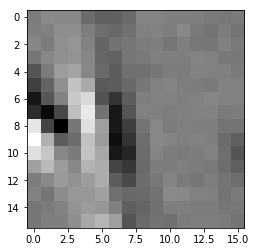

In [351]:
plt.imshow(pop_datapoints["test"].images[max_curvature_direction+50,:].reshape(16,16), cmap="Greys_r")
plt.show()

Text(0.5,1,'Basis Function')

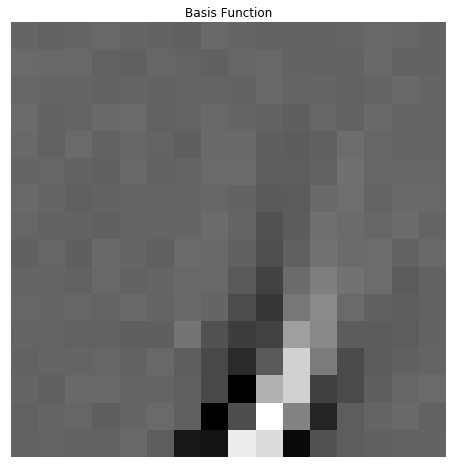

In [339]:
fig, ax = plt.subplots(1, figsize=(8,8))
ax = pf.clear_axis(ax)
ax.imshow(analyzer.bf_stats["basis_functions"][neuron_idx], cmap="Greys_r")
ax.set_title("Basis Function")

#### Questions
I think I've found the orthogonal direction (i.e. neuron? - not necessarily) that bfid1 is maximally equivariant to
but if I plot the neuron with this index I get the original neuron?
if I plot an image at this index it looks like it is somewhere along the line?
Maybe I'm at the beginning of the index, and it goes away from here...
How was the same neuron in the set of possilbe neurons, when the shape is num_neurons-1
I want to produce num_imgs (100) plots of the images that created an endo-origin curvature


In [ ]:
# Find datapoints along one contour
target_activity = 0.2
eps = 0.05
neuron_activity = norm_activity[:, bf_id1]
iso_activities = neuron_activity[neuron_activity>target_activity-eps]
iso_activities = iso_activities[iso_activities<target_activity+eps]
iso_indices = np.arange(neuron_activity.shape[0])[np.in1d(neuron_activity, iso_activities)]
print("Plotting",len(iso_indices), "datapoints with responeses within eps =",eps,"of target =",target_activity)

fig, ax = plt.subplots(1)
#cmap = plt.get_cmap('tab20b')
cmap = plt.get_cmap('viridis')
#cmap = plt.get_cmap('jet')
vmin = 0.0
vmax = 1.0
cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
rank_indices = np.argsort(neuron_activity)
colors = [None]*len(rank_indices)
for data_id in rank_indices:
  if data_id in iso_indices:
    colors[data_id] = scalarMap.to_rgba(neuron_activity[data_id])
  else:
    colors[data_id] = scalarMap.to_rgba(0.0)
#colors = [scalarMap.to_rgba(neuron_activity[data_id]) for data_id in rank_indices if data_id in iso_indices]
ax.scatter(proj_datapoints[:,0][rank_indices], proj_datapoints[:,1][rank_indices], c=colors, s=5.0)
ax.arrow(0, 0, proj_neuron1[1].item(), proj_neuron1[0].item(), head_width=0.05, head_length=0.05, fc='r', ec='r')
ax.arrow(0, 0, proj_neuron2[1].item(), proj_neuron2[0].item(), head_width=0.05, head_length=0.05, fc='k', ec='k')
ax.set_title("Angle = "+str(neuron_angles[bf_id1, bf_id2])+" rad")
ax.set_ylim([-2, 2.0])
ax.set_xlim([-2, 2.0])
scalarMap._A = []
cbar = fig.colorbar(scalarMap, ax=ax, ticks=[0, 1], aspect=10)
plt.show()

target_datapoints = datapoints[iso_indices,:] - np.mean(datapoints[iso_indices,:])
iso_cov = np.dot(target_datapoints.T, target_datapoints)
evals, evecs = np.linalg.eigh(iso_cov) 

fig1 = pf.plot_weights(evecs.T.reshape(256, 16, 16)[::-1,...])

fig2 = pf.plot_eigenvalues(evals[::-1])

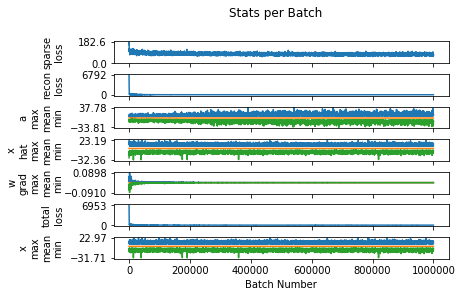

In [14]:
#keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
#labels=["activity", "recon loss", "sparse loss", "total loss"]
#keys=["a_fraction_active", "recon_loss", "entropy_loss", "total_loss"]
#labels=["activity", "recon loss", "entropy loss", "total loss"]
stats_fig = pf.plot_stats(analyzer.run_stats)#, keys=keys, labels=labels)
stats_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_train_stats.png")

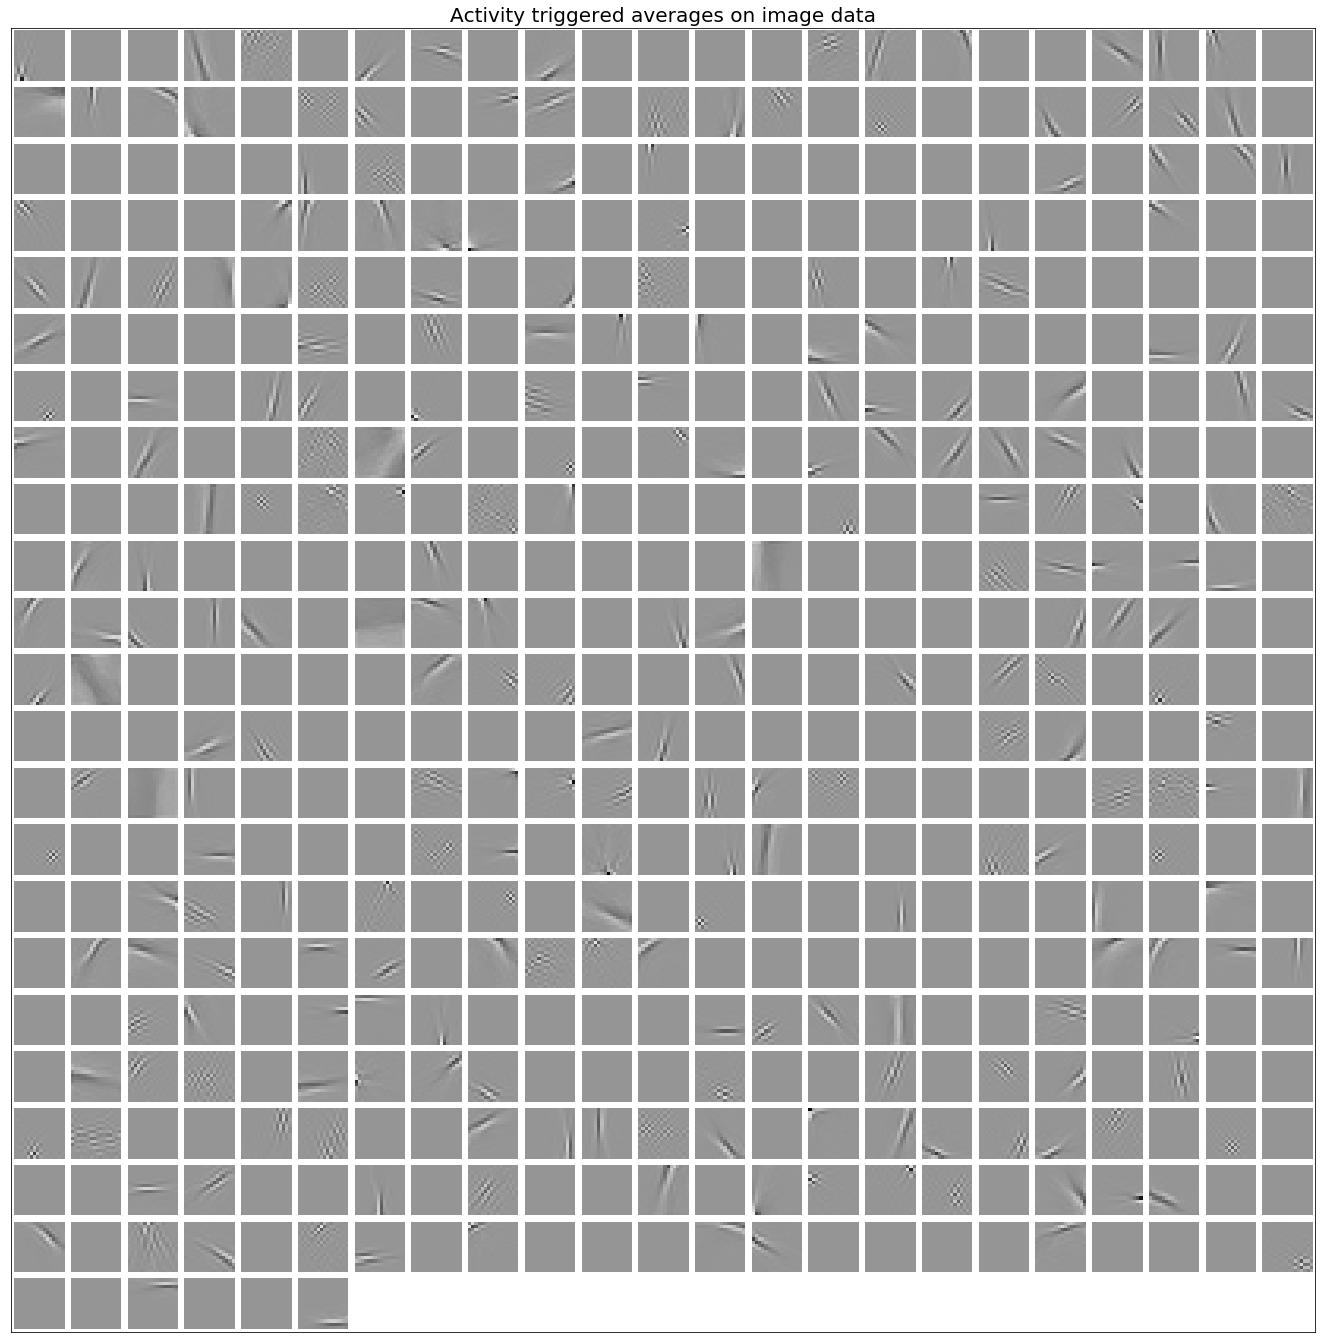

In [15]:
atas_fig = pf.plot_data_tiled(analyzer.atas.T, normalize=False, title="Activity triggered averages on image data")
atas_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_img_atas.png")

In [16]:
num_noise_images = 10000
noise_images = np.random.standard_normal([num_noise_images]+analyzer.model_params["data_shape"])
noise_activity = analyzer.compute_activations(noise_images)
noise_atas = analyzer.compute_atas(noise_activity, noise_images)
noise_atcs = analyzer.compute_atcs(noise_activity, noise_images, noise_atas)

AssertionError: sparse_mult was not found in the schedule.

In [17]:
noise_atas_fig = pf.plot_data_tiled(noise_atas.T, normalize=False, title="Activity triggered averages on standard normal noise data")
noise_atas_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_noise_atas.png")

NameError: name 'noise_atas' is not defined

In [18]:
neuron_idx=0
evals, evecs = np.linalg.eigh(noise_atcs[neuron_idx,...]) 
top_indices = np.argsort(evals)[::-1]
fig = pf.plot_weights(evecs.T.reshape(256,16,16)[top_indices,:,:])
fig2 = pf.plot_eigenvalues(evals[::-1], ylim=[np.min(evals), np.max(evals)])

NameError: name 'noise_atcs' is not defined

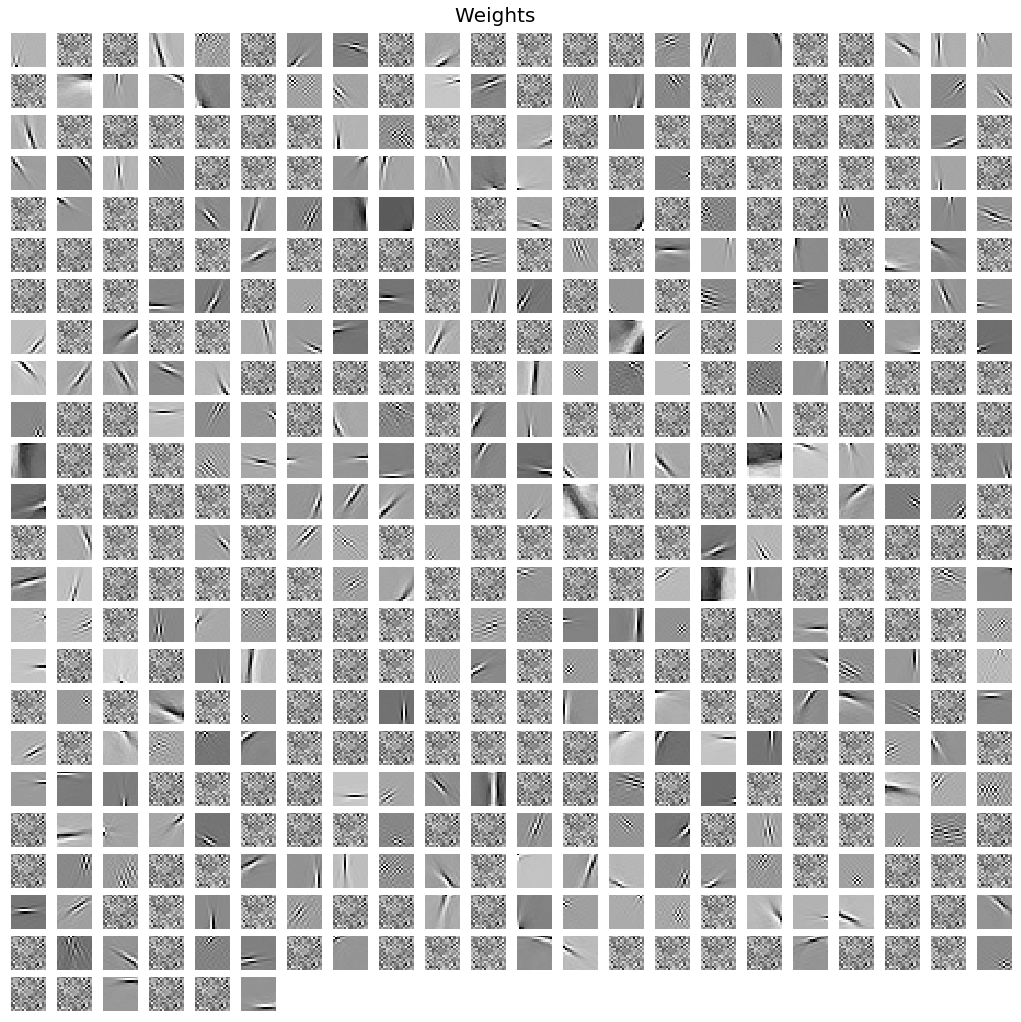

In [21]:
#dict_fig = pf.plot_data_tiled(analyzer.evals["weights/phi:0"].T, normalize=False, title="Weights")
weight_shape = [analyzer.bf_stats["num_outputs"], analyzer.bf_stats["patch_edge_size"], analyzer.bf_stats["patch_edge_size"]]
dict_fig = pf.plot_weights(analyzer.evals["weights/phi:0"].T.reshape(weight_shape), title="Weights")
dict_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_dict.png")

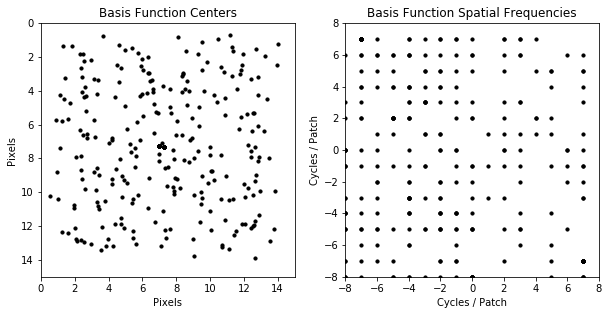

In [20]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"fig_location_frequency_centers.png")

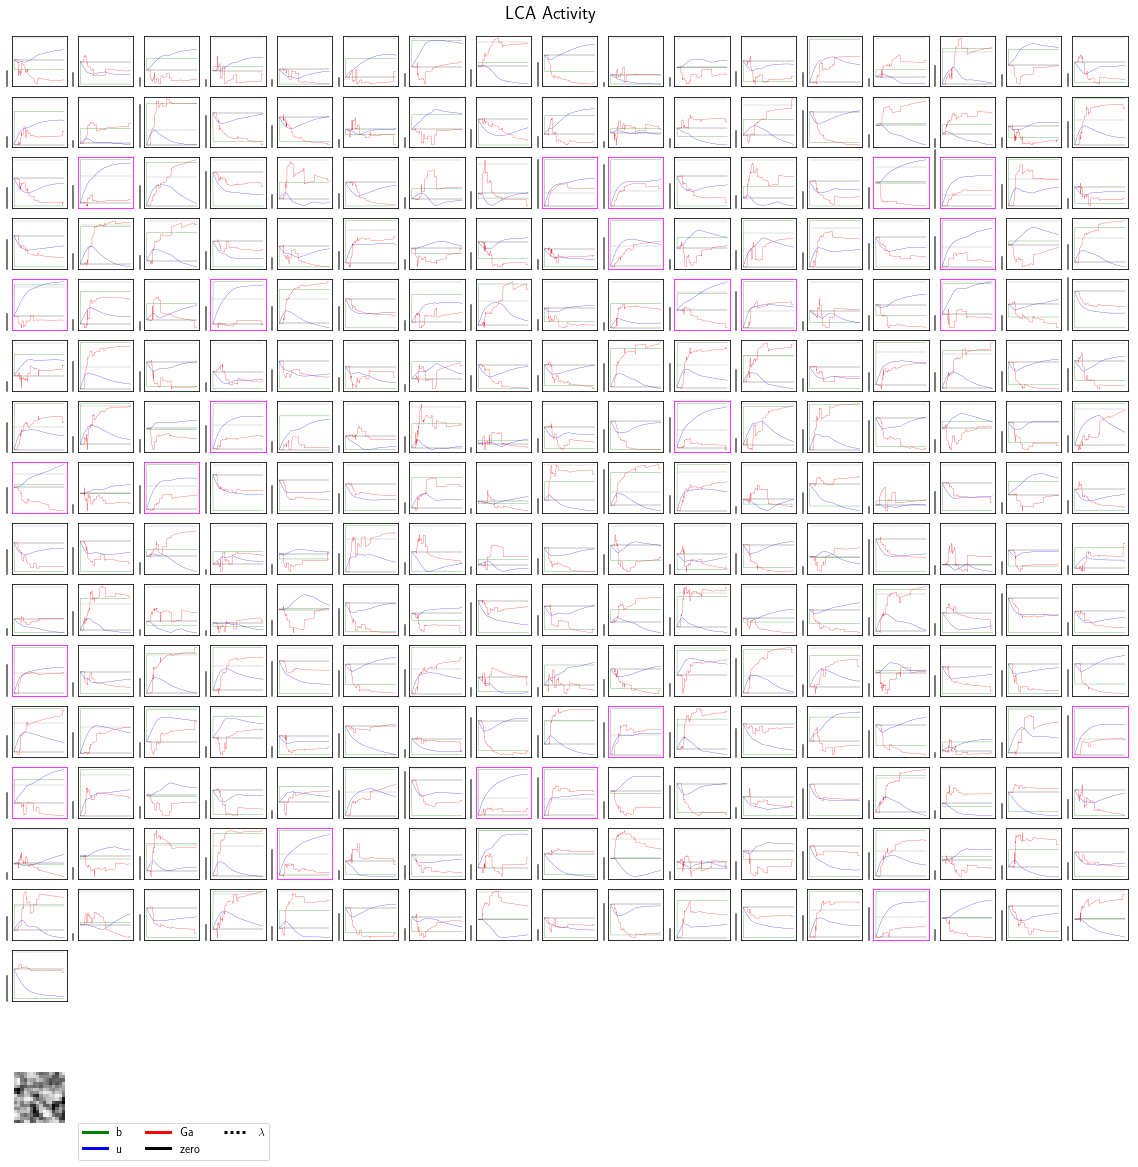

In [43]:
inf_trace_fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"])
inf_trace_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_inference_traces.pdf")

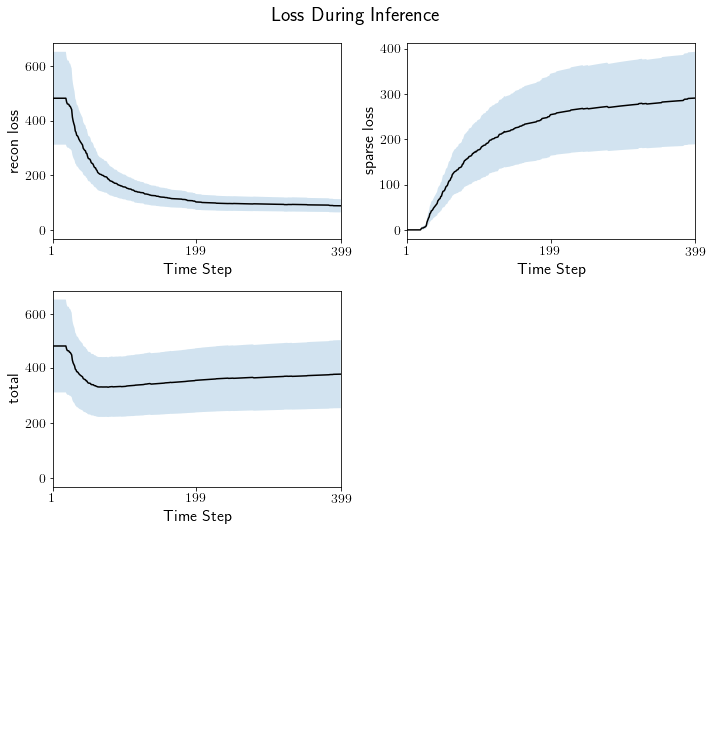

In [44]:
inf_stats_fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")
inf_stats_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_inference_loss.png")

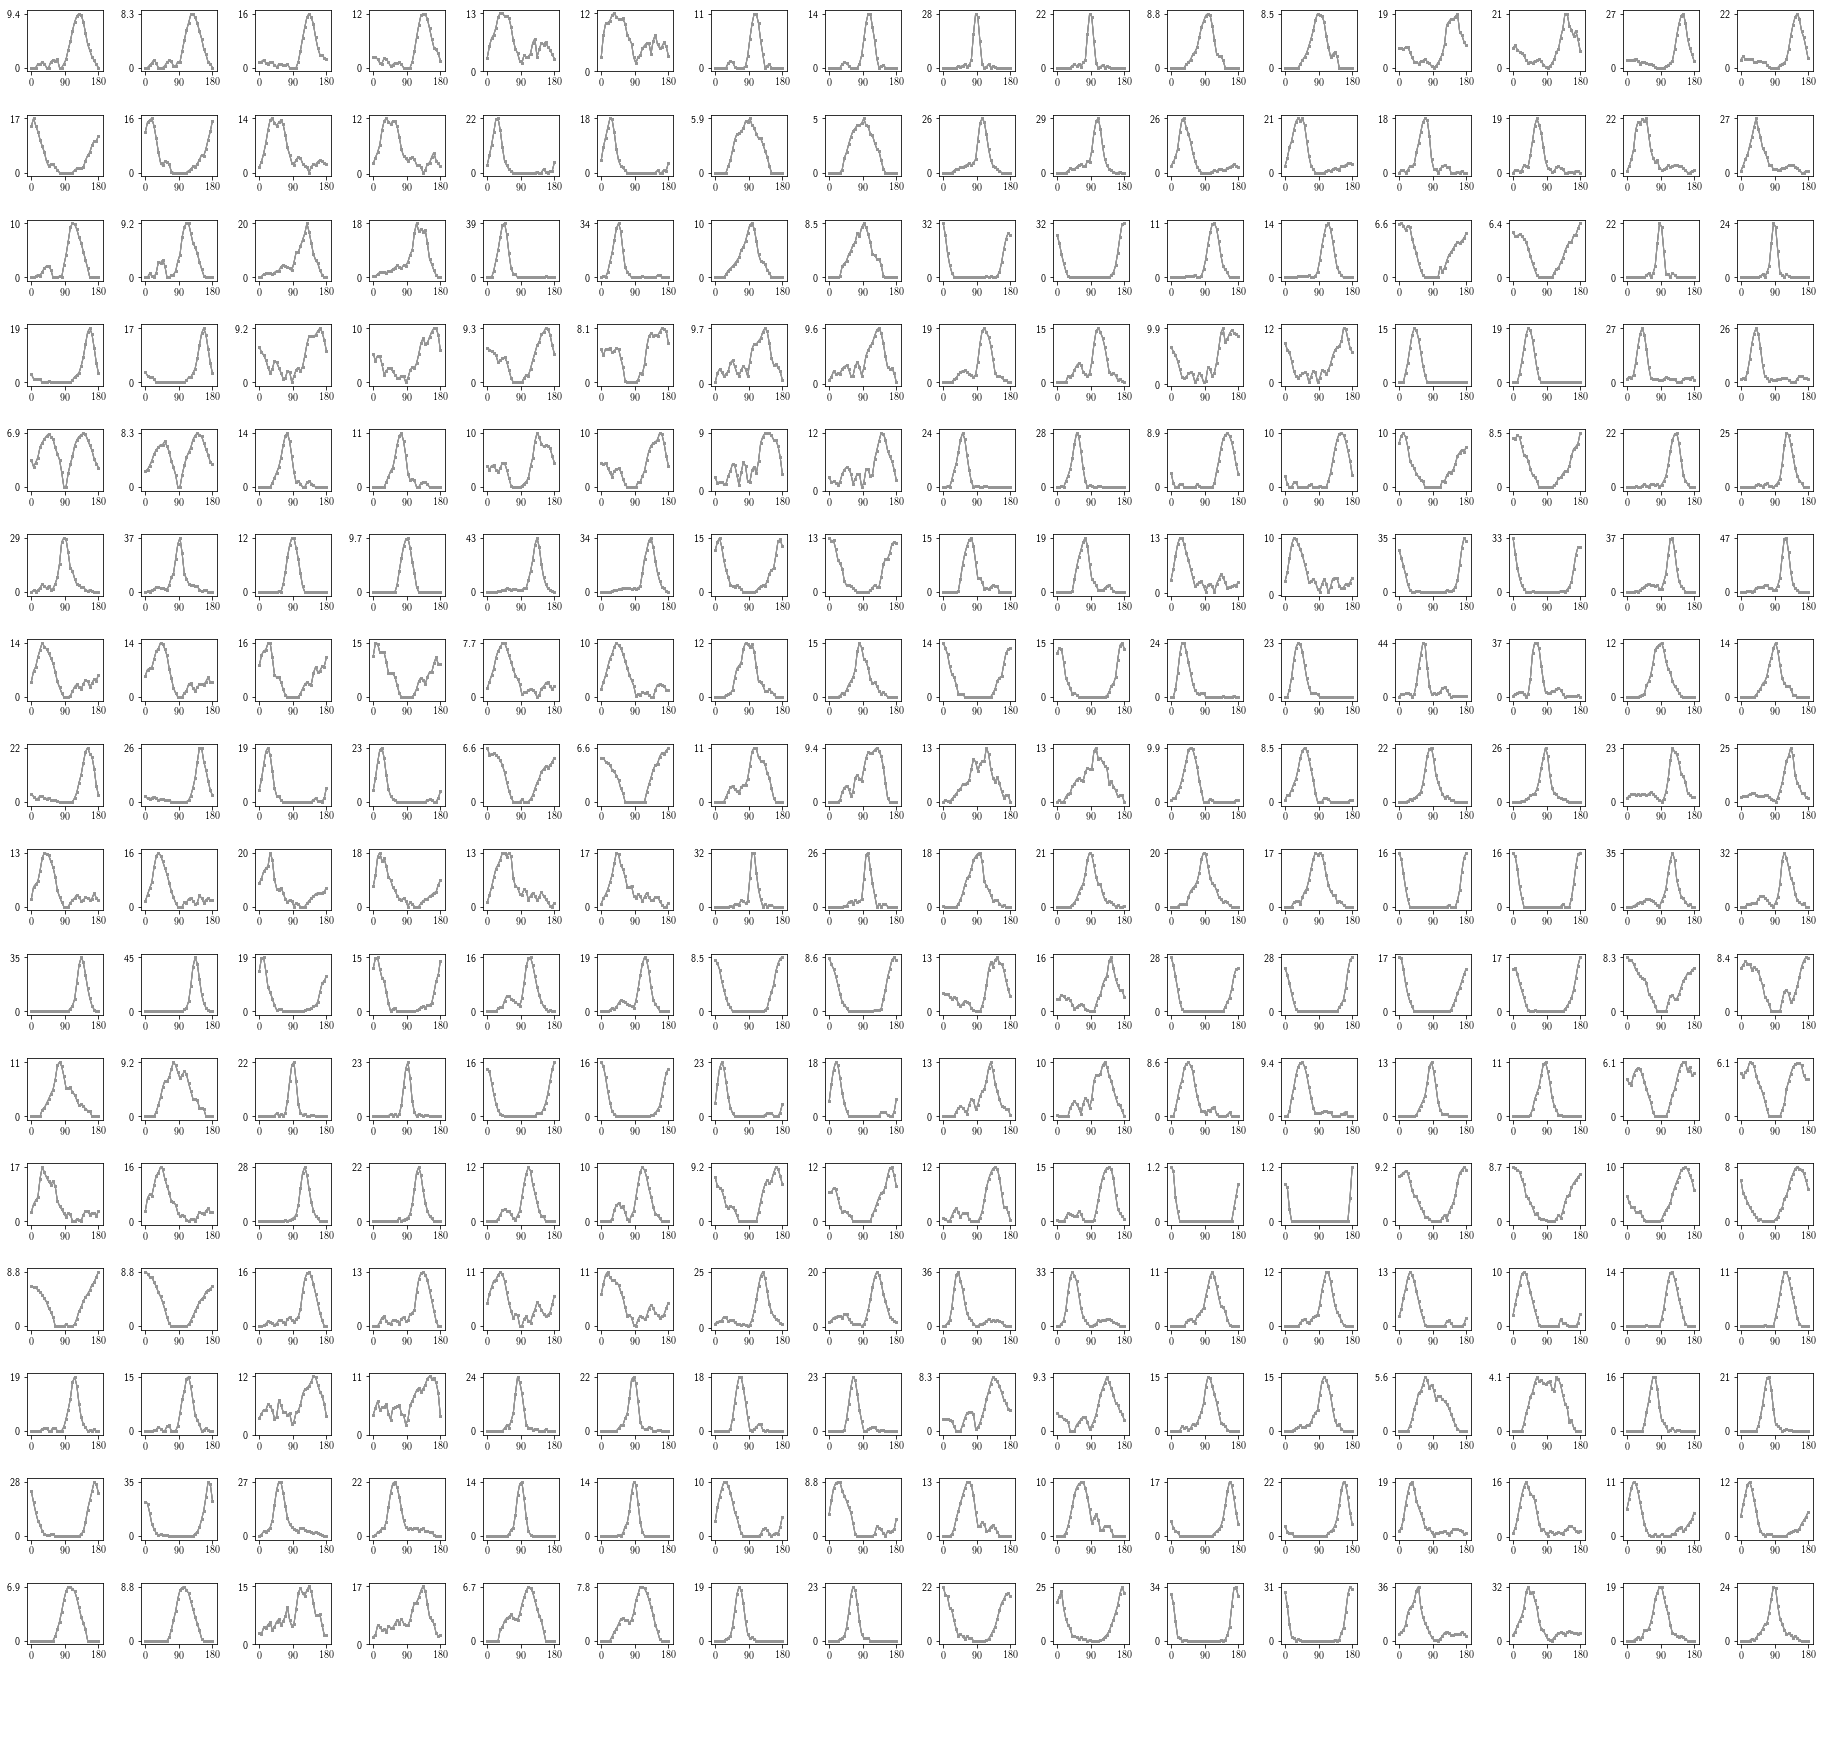

In [51]:
ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, analyzer.ot_grating_responses["rectified_responses"].reshape(512,5,32))
#ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, ot_mean_activations)
#ot_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_orientation_tuning.pdf")

In [ ]:
#cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, analyzer.co_grating_responses["test_mean_responses"])
cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, co_test_mean_responses)
cross_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_cross_orientation_tuning.pdf")

In [ ]:
cross_contrast_fig = pf.plot_plaid_contrast_tuning(co_bf_indices, co_contrasts, co_contrasts, co_base_orientations,
  co_mask_orientations, co_test_mean_responses)
cross_contrast_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_cross_contrast_orientation_tuning.pdf")

In [ ]:
#grating = lambda bf_idx,orientation,phase,contrast:dp.generate_grating(
#  *dp.get_grating_params(bf_stats=analyzer.bf_stats, bf_idx=bf_idx, orientation=orientation,
#  phase=phase, contrast=contrast, diameter=-1)).reshape(16,16)
#
#bf_idx = 29
#bf = analyzer.evals["weights/phi:0"].T[co_bf_indices[bf_idx],:].reshape(16,16)
#base_stim = grating(co_bf_indices[bf_idx], co_base_orientations[bf_idx], co_phases[0], 0.5)
#mask_stim = grating(co_bf_indices[bf_idx], orthogonal_orientations[bf_idx], co_phases[5], 0.5)
#test_stim = base_stim + mask_stim
#
#all_min = np.min(np.stack([base_stim, mask_stim, test_stim]))
#all_max = np.max(np.stack([base_stim, mask_stim, test_stim]))
#
#fig, axes = plt.subplots(4)
#axes[0] = pf.clear_axis(axes[0])
#axes[1] = pf.clear_axis(axes[1])
#axes[2] = pf.clear_axis(axes[2])
#axes[3] = pf.clear_axis(axes[3])
#axes[0].imshow(bf, cmap="Greys_r")
#axes[1].imshow(base_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[2].imshow(mask_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[3].imshow(test_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#plt.show()
#fig.savefig("/home/dpaiton/tmp_figs/"+analysis_params["model_name"]+"_ex_cross_stim.png")

In [ ]:
#constructed_bfs = np.zeros_like(analyzer.evals["weights/phi:0"].T)
#for bf_idx in range(constructed_bfs.shape[0]):
#  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
#  grating = dp.generate_grating(*params)
#  constructed_bfs[bf_idx,...] = grating.reshape(256)
#fig = pf.plot_data_tiled(constructed_bfs)

### compute iso_response_contrast curves

In [ ]:
outputs = analyzer.iso_response_contrasts(analyzer.bf_stats, base_contrast=0.5, contrast_resolution=0.01,
  closeness=0.01, num_alt_orientations=4, orientations=np.linspace(0.0, np.pi, 16),
  phases = np.linspace(-np.pi, np.pi, 12), neuron_indices=[52,53,54], diameter=-1,
  scale=analyzer.analysis_params["input_scale"])

In [ ]:
outputs["iso_response_parameters"][0]